In [58]:
import numpy as np
from collections import Counter

## Algorithm Implementation

### Create A Node Class

In [59]:
class Node:
    def __init__(self, feature = None, threshold = None, left = None, right = None, *, value = None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value
        
    def is_leaf_node(self):
        return self.value is not None

### Create Decision Tree Class

In [60]:
class DecisionTree:
    def __init__(self, min_samples_split=2, max_depth=100, n_features=None):
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.n_features = n_features
        self.root = None

    def fit(self, X, y):
        self.n_features = X.shape[1] if not self.n_features else min(X.shape[1], self.n_features)
        self.root = self._grow_tree(X, y)

    def _grow_tree(self, X, y, depth=0):
        n_samples, n_feats = X.shape
        n_labels = len(np.unique(y))

        # Check the stopping criteria
        if (depth >= self.max_depth or n_labels == 1 or n_samples < self.min_samples_split):
            leaf_value = self._most_common_label(y)
            return Node(value=leaf_value)

        feat_idxs = np.random.choice(n_feats, self.n_features, replace=False)

        # Find the best split
        best_feature, best_threshold = self._best_split(X, y, feat_idxs)

        # If no valid split is found, create a leaf node
        if best_feature is None or best_threshold is None:
            leaf_value = self._most_common_label(y)
            return Node(value=leaf_value)

        # Create child nodes
        left_idxs, right_idxs = self._split(X[:, best_feature], best_threshold)

        # Ensure splits are valid
        if left_idxs is None or right_idxs is None:
            leaf_value = self._most_common_label(y)
            return Node(value=leaf_value)

        left = self._grow_tree(X[left_idxs, :], y[left_idxs], depth + 1)
        right = self._grow_tree(X[right_idxs, :], y[right_idxs], depth + 1)
        return Node(best_feature, best_threshold, left, right)

    def _best_split(self, X, y, feat_idxs):
        best_gain = -1
        split_idx, split_threshold = None, None

        for feat_idx in feat_idxs:
            X_column = X[:, feat_idx]
            thresholds = np.unique(X_column)

            for thresh in thresholds:
                # Calculate the information gain
                gain = self._information_gain(y, X_column, thresh)

                if gain > best_gain:
                    best_gain = gain
                    split_idx = feat_idx
                    split_threshold = thresh

        return split_idx, split_threshold

    def _information_gain(self, y, X_column, threshold):
        # Parent entropy
        parent_entropy = self._entropy(y)

        # Create children
        left_idxs, right_idxs = self._split(X_column, threshold)

        # Return 0 if no valid split
        if left_idxs is None or right_idxs is None:
            return 0

        # Calculate the weighted avg entropy of the children 
        n = len(y)
        n_left, n_right = len(left_idxs), len(right_idxs)
        e_left, e_right = self._entropy(y[left_idxs]), self._entropy(y[right_idxs])
        child_entropy = (n_left / n) * e_left + (n_right / n) * e_right

        # Calculate the Information Gain
        information_gain = parent_entropy - child_entropy
        return information_gain

    def _split(self, X_column, split_thresh):
        left_idxs = np.argwhere(X_column <= split_thresh).flatten()
        right_idxs = np.argwhere(X_column > split_thresh).flatten()

        # Avoid splitting if it results in empty sets
        if len(left_idxs) == 0 or len(right_idxs) == 0:
            return None, None

        return left_idxs, right_idxs

    def _entropy(self, y):
        hist = np.bincount(y)
        ps = hist / len(y)
        return -np.sum([p * np.log(p) for p in ps if p > 0])

    def _most_common_label(self, y):
        if len(y) == 0:
            raise ValueError("The input array 'y' is empty. Cannot determine the most common label.")

        counter = Counter(y)
        if not counter:
            raise ValueError("Counter is empty. Cannot determine the most common label.")

        value = counter.most_common(1)[0][0]
        return value

    def predict(self, X):
        return np.array([self._traverse_tree(x, self.root) for x in X])

    def _traverse_tree(self, x, node):
        if node.is_leaf_node():
            return node.value

        if x[node.feature] <= node.threshold:
            return self._traverse_tree(x, node.left)
        return self._traverse_tree(x, node.right)

### Imoprt Libraries and Dataset

In [61]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
import numpy as np

In [62]:
data = datasets.load_breast_cancer()
X,y = data.data, data.target
print('X shape: ',X.shape)
print('y shape: ',y.shape)

X shape:  (569, 30)
y shape:  (569,)


#### Split Data into Training and Test Set

In [63]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1234)

### Train Decision Trees

In [64]:
classifier = DecisionTree()
classifier.fit(X_train, y_train)

### Predictions With Decision Trees

In [65]:
predictions = classifier.predict(X_test)

accuracy = np.mean(predictions == y_test)
print(accuracy)

0.9385964912280702


### Let's try max depth 10

In [66]:
classifier = DecisionTree(max_depth = 5)
classifier.fit(X_train, y_train)

predictions = classifier.predict(X_test)

accuracy = np.mean(predictions == y_test)
print(accuracy)

0.9122807017543859


### Let's Try for actual dataset

In [67]:
import pandas as pd
dataframe = pd.read_csv('Social_Network_Ads.csv')
dataframe.head()

,Age,EstimatedSalary,Purchased
0,19,19000,0
1,35,20000,0
2,26,43000,0
3,27,57000,0
4,19,76000,0


#### Now Let's Split the Data set into training and test set

In [68]:
X = dataframe.iloc[:, 0 : 2].values
y = dataframe.iloc[:,-1].values
print('X Shape :', X.shape)
print('y Shape :', y.shape)

X Shape : (400, 2)
y Shape : (400,)


In [69]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1234)
print("X_train Shape :", X_train.shape)
print("y_train Shape :", y_train.shape)
print("X_test Shape :", X_test.shape)
print("y_test Shape :", y_test.shape)

X_train Shape : (320, 2)
y_train Shape : (320,)
X_test Shape : (80, 2)
y_test Shape : (80,)


### Features Scaling

In [70]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)


### Let's Train the model & make predictions

In [71]:
classifier = DecisionTree(max_depth = 5, min_samples_split = 2)
classifier.fit(X_train,y_train)
predictions = classifier.predict(X_test)

#### Now Let's Check Accuracy

In [72]:
accuracy = np.mean(predictions == y_test)
print(accuracy)

0.9125


### Now Let's Use the Scikit-Learn for Decision Tree

Let's compare the results

In [73]:
from sklearn import tree

In [77]:
clf = tree.DecisionTreeClassifier(max_depth=5,min_samples_split=2)
clf.fit(X_train, y_train) # Use the scale test set as before
pred = clf.predict(X_test) # Use the scale test set as before
print(np.mean(pred == y_test))

0.875


### Results from using our own from scratch Decision Trees 

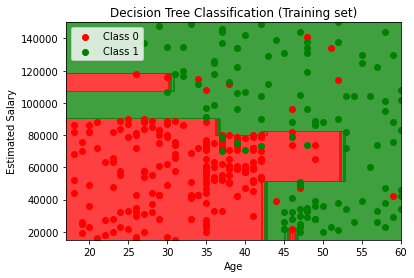

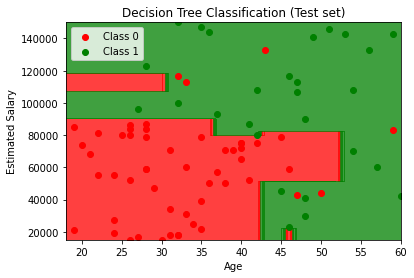

In [75]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Define a reasonable step size
step_size = 1  # Increase this value to reduce memory usage

# Visualising the Training set results
X_set, y_set = sc.inverse_transform(X_train), y_train
X1, X2 = np.meshgrid(np.arange(start=X_set[:, 0].min() - 1, stop=X_set[:, 0].max() + 1, step=step_size),
                     np.arange(start=X_set[:, 1].min() - 1, stop=X_set[:, 1].max() + 1, step=step_size))

# Predicting on mesh grid with subsampling
Z = classifier.predict(sc.transform(np.c_[X1.ravel(), X2.ravel()]))
Z = Z.reshape(X1.shape)

# Plotting decision boundary
plt.contourf(X1, X2, Z, alpha=0.75, cmap=ListedColormap(('red', 'green')))
plt.xlim(X1.min(), X1.max())
plt.ylim(X2.min(), X2.max())

# Plotting training points with subsampling
for i, j in enumerate(np.unique(y_set)):
    plt.scatter(X_set[y_set == j, 0], X_set[y_set == j, 1], 
                color=ListedColormap(('red', 'green'))(i), label=f'Class {j}')
    
plt.title('Decision Tree Classification (Training set)')
plt.xlabel('Age')
plt.ylabel('Estimated Salary')
plt.legend()
plt.show()

# Visualising the Test set results
X_set, y_set = sc.inverse_transform(X_test), y_test
X1, X2 = np.meshgrid(np.arange(start=X_set[:, 0].min() - 1, stop=X_set[:, 0].max() + 1, step=step_size),
                     np.arange(start=X_set[:, 1].min() - 1, stop=X_set[:, 1].max() + 1, step=step_size))

# Predicting on mesh grid with subsampling
Z = classifier.predict(sc.transform(np.c_[X1.ravel(), X2.ravel()]))
Z = Z.reshape(X1.shape)

# Plotting decision boundary
plt.contourf(X1, X2, Z, alpha=0.75, cmap=ListedColormap(('red', 'green')))
plt.xlim(X1.min(), X1.max())
plt.ylim(X2.min(), X2.max())

# Plotting test points with subsampling
for i, j in enumerate(np.unique(y_set)):
    plt.scatter(X_set[y_set == j, 0], X_set[y_set == j, 1], 
                color=ListedColormap(('red', 'green'))(i), label=f'Class {j}')
    
plt.title('Decision Tree Classification (Test set)')
plt.xlabel('Age')
plt.ylabel('Estimated Salary')
plt.legend()
plt.show()

### Results from using scikit-learn Decision Trees

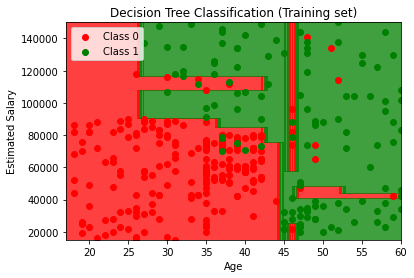

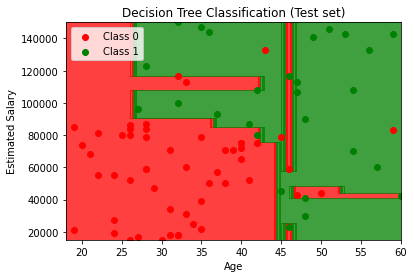

In [78]:
# Define a reasonable step size
step_size = 1  # Increase this value to reduce memory usage

# Visualising the Training set results
X_set, y_set = sc.inverse_transform(X_train), y_train
X1, X2 = np.meshgrid(np.arange(start=X_set[:, 0].min() - 1, stop=X_set[:, 0].max() + 1, step=step_size),
                     np.arange(start=X_set[:, 1].min() - 1, stop=X_set[:, 1].max() + 1, step=step_size))

# Predicting on mesh grid with subsampling
Z = clf.predict(sc.transform(np.c_[X1.ravel(), X2.ravel()]))
Z = Z.reshape(X1.shape)

# Plotting decision boundary
plt.contourf(X1, X2, Z, alpha=0.75, cmap=ListedColormap(('red', 'green')))
plt.xlim(X1.min(), X1.max())
plt.ylim(X2.min(), X2.max())

# Plotting training points with subsampling
for i, j in enumerate(np.unique(y_set)):
    plt.scatter(X_set[y_set == j, 0], X_set[y_set == j, 1], 
                color=ListedColormap(('red', 'green'))(i), label=f'Class {j}')
    
plt.title('Decision Tree Classification (Training set)')
plt.xlabel('Age')
plt.ylabel('Estimated Salary')
plt.legend()
plt.show()

# Visualising the Test set results
X_set, y_set = sc.inverse_transform(X_test), y_test
X1, X2 = np.meshgrid(np.arange(start=X_set[:, 0].min() - 1, stop=X_set[:, 0].max() + 1, step=step_size),
                     np.arange(start=X_set[:, 1].min() - 1, stop=X_set[:, 1].max() + 1, step=step_size))

# Predicting on mesh grid with subsampling
Z = clf.predict(sc.transform(np.c_[X1.ravel(), X2.ravel()]))
Z = Z.reshape(X1.shape)

# Plotting decision boundary
plt.contourf(X1, X2, Z, alpha=0.75, cmap=ListedColormap(('red', 'green')))
plt.xlim(X1.min(), X1.max())
plt.ylim(X2.min(), X2.max())

# Plotting test points with subsampling
for i, j in enumerate(np.unique(y_set)):
    plt.scatter(X_set[y_set == j, 0], X_set[y_set == j, 1], 
                color=ListedColormap(('red', 'green'))(i), label=f'Class {j}')
    
plt.title('Decision Tree Classification (Test set)')
plt.xlabel('Age')
plt.ylabel('Estimated Salary')
plt.legend()
plt.show()

### Comparing the results

Now you can see that the accuracy of our implemented classifier is above 90% and the accuracy of the classifier from scikit-learn is below 90 for this specific dataset

Also from the plots above, you can clearly see where the classifier from sklearn is overfitting. Our implemented classifier is aslo overfitting but just in one part of the data